In [53]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt

In [54]:
env = gym.make('CartPole-v1')

In [55]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = nn.Sequential(
                nn.Linear(n_state, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_action),
                nn.Softmax(),
            )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def predict(self, s):
        """
        Вычисляет вероятности действий в состоянии s,
        применяя обученную модель
        @param s: входное состояние
        @return: предсказанная стратегия
        """
        return self.model(torch.Tensor(s))
    
    def update(self, advantages, log_probs):
        """
        Обновляет веса сети стратегии на основе обучающих примеров
        @param advantages: преимущества на каждом шаге эпизода
        @param log_probs: логарифмы вероятностей на каждом шаге
        """
        policy_gradient = []
        for log_prob, At in zip(log_probs, advantages):
            policy_gradient.append(-log_prob * At)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        """
        Предсказывает стратегию, выбирает действие и вычисляет логарифм
        его вероятности
        @param s: входное состояние
        @return: выбранное действие и логарифм его вероятности
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob
    
    

In [56]:
class ValueNetwork():
    def __init__(self, n_state, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                     torch.nn.Linear(n_state, n_hidden),
                     torch.nn.ReLU(),
                     torch.nn.Linear(n_hidden, 1)
                     )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        """
        Обновить веса DQN, получив обучающий пример
        @param s: состояния
        @param y: целевые ценности
        """
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        """
        Вычисляет значения Q-функции состояния для всех действий,
        применяя обученную модель
        @param s: входное состояние
        @return: значения Q-функции состояния для всех действий
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))

In [57]:
def reinforce(env, estimator_policy, estimator_value, n_episode, total_reward_episode, gamma=1.0):
    """
    Алгоритм REINFORCE с базой
    @param env: имя окружающей среды Gym
    @param estimator: сеть стратегии
    @param estimator_value: сеть ценности
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    """
    for episode in tqdm(range(n_episode)):
        log_probs = []
        states = []
        rewards = []
        state, _ = env.reset()
        while True:
            states.append(state)
            action, log_prob = estimator_policy.get_action(state)
            next_state, reward, is_done, is_break, _ = env.step(action)
            total_reward_episode[episode] += reward

            log_probs.append(log_prob)
            rewards.append(reward)

            if is_done or is_break:
                Gt = 0
                pw = 0
                returns = []
                for t in range(len(states)-1, -1, -1):
                    Gt += gamma ** pw * rewards[t]
                    pw += 1
                    returns.append(Gt)
                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / ( returns.std() + 1e-9)

                baseline_values = estimator_value.predict(states)
                
                advantages = returns - baseline_values
                estimator_value.update(states, returns)
                
                estimator_policy.update(advantages, log_probs)
                #print('Эпизод: {}, полное вознаграждение: {}'.format(episode, total_reward_episode[episode]))
                break
        state = next_state

In [58]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden_p = 128
lr_p = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden_p, lr_p)

gamma = 0.9

n_hidden_v = 128
lr_v = 0.003
value_net = ValueNetwork(n_state, n_hidden_v, lr_v)

n_episode = 2000
total_reward_episode = [0] * n_episode
reinforce(env, policy_net, value_net, n_episode, total_reward_episode, gamma)

100%|██████████| 2000/2000 [00:14<00:00, 142.77it/s]


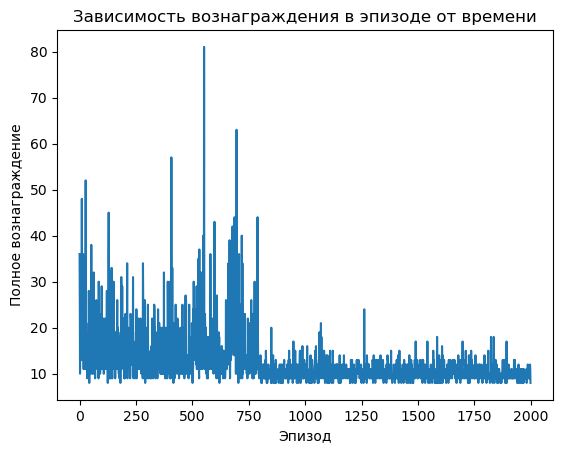

In [59]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()